# Predicting Movie Genres from Script Data

In this notebook, we create models to predict movie genres based on their scripts. Afterward, we look into the accuracy of these models.


1. Contents
2. Setup
3. Pre-Processing
4. Data Exploration 
5. Multi-Label Classification
    1. k-Nearest Neighbors (k-NN)
    2. OneVsRestClassifier
        1. Naïve Bayes
        2. Linear with Stochastic Gradient Descent
        3. Logistic Regression with SVD-Transformed Texts
7. Accuracy Summary
8. Sources

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [3]:
from imsdb import get_imsdb
from clean_imsdb import clean_imsdb
from fuzzy import fuzz_merge

In [4]:
 # Create random state
rng = np.random.RandomState(20201118)

# Make plot colors a bit more accessible
sns.set_palette('colorblind');

# Number of jobs to run in parallel
NJOBS = 8

## Pre-Processing

Before getting anything, we'll need to get the movie script data. We can use the file `imsdb.py` to obtain movie script data. The function `get_imsdb()` uses `BeautifulSoup` to scrape IMSDB in order to obtain the movie scripts and metadata and then writes that information out for our consumption. We lifted the majority of the code from a [repo created by Aveek Sasha](https://github.com/Aveek-Saha/Movie-Script-Database). (Originally, we planned to just use his project for this. But for some reason his project wouldn't run as is.) It takes about 11 minutes to run on our computers.

In [5]:
get_imsdb()

imsdb:   2%|▏         | 21/1211 [00:18<22:38,  1.14s/it]

https://imsdb.com/scripts/8-Mile.pdf
HTTP Error 404: Not Found


imsdb:  10%|█         | 123/1211 [01:35<14:08,  1.28it/s]

https://imsdb.com/scripts/Back-to-the-Future.pdf
HTTP Error 404: Not Found


imsdb:  16%|█▌        | 193/1211 [02:27<13:09,  1.29it/s]

https://imsdb.com/scripts/Blues-Brothers%2C-The.pdf
HTTP Error 404: Not Found


imsdb:  22%|██▏       | 272/1211 [03:30<12:27,  1.26it/s]

https://imsdb.com/scripts/Clockwork-Orange%2C-A.pdf
HTTP Error 404: Not Found


imsdb:  24%|██▍       | 292/1211 [03:48<13:01,  1.18it/s]

https://imsdb.com/scripts/Courage-Under-Fire.pdf
HTTP Error 404: Not Found


imsdb:  32%|███▏      | 384/1211 [04:59<11:33,  1.19it/s]

https://imsdb.com/scripts/Equilibrium.pdf
HTTP Error 404: Not Found


imsdb:  51%|█████     | 614/1211 [07:45<07:46,  1.28it/s]

https://imsdb.com/scripts/Jade.pdf
HTTP Error 404: Not Found


imsdb:  53%|█████▎    | 646/1211 [08:10<12:13,  1.30s/it]

https://imsdb.com/scripts/Kiss-of-the-Spider-Woman.pdf
HTTP Error 404: Not Found


imsdb:  57%|█████▋    | 689/1211 [08:42<07:38,  1.14it/s]

https://imsdb.com/scripts/Lion-King%2C-The.pdf
HTTP Error 404: Not Found


imsdb:  64%|██████▍   | 775/1211 [09:50<06:54,  1.05it/s]

https://imsdb.com/scripts/Monster%27s-Ball.pdf
HTTP Error 404: Not Found


imsdb:  65%|██████▍   | 783/1211 [09:56<05:34,  1.28it/s]

https://imsdb.com/scripts/Mr.-Holland%27s-Opus.pdf
HTTP Error 404: Not Found


imsdb:  68%|██████▊   | 823/1211 [10:40<08:44,  1.35s/it]

HTTP Error 404: Not Found
HTTP Error 404: Not Found


imsdb:  69%|██████▊   | 831/1211 [10:47<05:29,  1.15it/s]

https://imsdb.com/scripts/Officer-and-a-Gentleman%2C-An.pdf
HTTP Error 404: Not Found


imsdb:  77%|███████▋  | 928/1211 [12:01<03:37,  1.30it/s]

https://imsdb.com/scripts/Robocop.pdf
HTTP Error 404: Not Found


imsdb:  80%|████████  | 972/1211 [12:36<03:46,  1.05it/s]

https://imsdb.com/scripts/Shadow-of-the-Vampire.pdf
HTTP Error 404: Not Found


imsdb:  83%|████████▎ | 1006/1211 [13:03<02:51,  1.20it/s]

https://imsdb.com/scripts/Sneakers.pdf
HTTP Error 404: Not Found


imsdb:  84%|████████▍ | 1021/1211 [13:13<02:22,  1.33it/s]

https://imsdb.com/scripts/Speed.pdf
HTTP Error 404: Not Found


imsdb:  87%|████████▋ | 1057/1211 [13:45<01:58,  1.30it/s]

https://imsdb.com/scripts/Superfights.pdf
HTTP Error 404: Not Found


imsdb:  95%|█████████▍| 1148/1211 [14:55<00:46,  1.36it/s]

https://imsdb.com/scripts/Vertigo.pdf
HTTP Error 404: Not Found


imsdb:  96%|█████████▋| 1168/1211 [15:10<00:33,  1.28it/s]

HTTP Error 404: Not Found
HTTP Error 404: Not Found


imsdb:  97%|█████████▋| 1172/1211 [15:13<00:30,  1.28it/s]

https://imsdb.com/scripts/When-Harry-Met-Sally.pdf
HTTP Error 404: Not Found


imsdb:  97%|█████████▋| 1179/1211 [15:18<00:21,  1.46it/s]

HTTP Error 404: Not Found
HTTP Error 404: Not Found


imsdb: 100%|██████████| 1211/1211 [15:41<00:00,  1.29it/s]


In [6]:
path, dirs, files = next(os.walk('scripts/unprocessed/imsdb'))
print('Number of scripts: ' + str(len(files)))

Number of scripts: 1127


We were able to pull 1,127 scripts from IMSDB's site.

Now that we've scraped the script data from imsdb, we'll need to combine the data into a dataframe. The function `clean_imsdb()` goes and reads in all of the scripts `get_imsdb()` outputted and then reformats the scripts to get rid of newline characters and multi-spaces so that the scripts have words separated by only spaces. After this, it pulls in the release date for the movies. Finally, it returns a dataframe that has `file_name`, `movie_title`, `script`, `release_date`, and `title_year`.

In [7]:
movie_scripts = clean_imsdb()
movie_scripts.head()

,file_name,movie_title,script,release_date,title_year
0,Midnight-Express.txt,Midnight Express,MIDNIGHT EXPRESS Screenplay by Oliver Stone B...,1978,Midnight Express (1978)
1,Big-Eyes.txt,Big Eyes,BIG EYES Written by Scott Alexander & Larry K...,2014,Big Eyes (2014)
2,Warrior.txt,Warrior,"WARRIOR Written by Gavin O'Connor, Anthony Ta...",2011,Warrior (2011)
3,Hellraiser-Hellseeker.txt,Hellraiser Hellseeker,HELLRAISER: HELLSEEKER Written by Carl Dupre ...,2002,Hellraiser Hellseeker (2002)
4,Hannah-and-Her-Sisters.txt,Hannah and Her Sisters,HANNAH AND HER SISTERS by Woody Allen As the ...,,Hannah and Her Sisters ()


Sweet! We have movie scripts to use for predicting genres. We just need to pull in genres from MovieLens

In [8]:
ml_path = './data/ml-25m/movies.csv'
ml_movies_df = pd.read_csv(ml_path)
ml_movies_df['year'] = ml_movies_df['title'].str.extract(r'\(([^()]+)\)')
ml_movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Since titles between imsdb and MovieLens aren't one-to-one, we can use a fuzzy match to try to associate them. The package `rapidfuzz` uses a Levenshtein distance to construct value representing the similarity of two strings. The function `process.extractOne` returns the highest-valued match between the strings. So we created a function called `fuzz_merge()` that takes two dataframes, two keys, and a lowest acceptable score, and returns a dataframe that has a column we can use to match the first with the second dataframe.

In [9]:
fuzzy_merged_movies_df = fuzz_merge(movie_scripts, ml_movies_df, 'title_year', 'title', lowest_acceptable_score=84)

In [10]:
fuzzy_merged_movies_df.head()

,file_name,movie_title,script,release_date,title_year,matched_title
0,Midnight-Express.txt,Midnight Express,MIDNIGHT EXPRESS Screenplay by Oliver Stone B...,1978,Midnight Express (1978),Midnight Express (1978)
1,Big-Eyes.txt,Big Eyes,BIG EYES Written by Scott Alexander & Larry K...,2014,Big Eyes (2014),Big Eyes (2014)
2,Warrior.txt,Warrior,"WARRIOR Written by Gavin O'Connor, Anthony Ta...",2011,Warrior (2011),Warrior (2011)
3,Hellraiser-Hellseeker.txt,Hellraiser Hellseeker,HELLRAISER: HELLSEEKER Written by Carl Dupre ...,2002,Hellraiser Hellseeker (2002),Hellraiser: Hellseeker (2002)
4,Hannah-and-Her-Sisters.txt,Hannah and Her Sisters,HANNAH AND HER SISTERS by Woody Allen As the ...,,Hannah and Her Sisters (),Hannah and Her Sisters (1986)


Now let's merge the MovieLens data with the IMSDB data.

In [11]:
movies_combined = fuzzy_merged_movies_df.merge(ml_movies_df, left_on='matched_title', right_on='title')
movies_combined.head()

,file_name,movie_title,script,release_date,title_year,matched_title,movieId,title,genres,year
0,Midnight-Express.txt,Midnight Express,MIDNIGHT EXPRESS Screenplay by Oliver Stone B...,1978,Midnight Express (1978),Midnight Express (1978),3498,Midnight Express (1978),Drama,1978
1,Big-Eyes.txt,Big Eyes,BIG EYES Written by Scott Alexander & Larry K...,2014,Big Eyes (2014),Big Eyes (2014),118985,Big Eyes (2014),Drama,2014
2,Warrior.txt,Warrior,"WARRIOR Written by Gavin O'Connor, Anthony Ta...",2011,Warrior (2011),Warrior (2011),89774,Warrior (2011),Drama,2011
3,Hellraiser-Hellseeker.txt,Hellraiser Hellseeker,HELLRAISER: HELLSEEKER Written by Carl Dupre ...,2002,Hellraiser Hellseeker (2002),Hellraiser: Hellseeker (2002),43022,Hellraiser: Hellseeker (2002),Horror,2002
4,Hannah-and-Her-Sisters.txt,Hannah and Her Sisters,HANNAH AND HER SISTERS by Woody Allen As the ...,,Hannah and Her Sisters (),Hannah and Her Sisters (1986),6993,Hannah and Her Sisters (1986),Comedy|Drama|Romance,1986


Lastly, we'll need to transform the pipe-separated list of genres into dummy variables in order to use them to predict the genres.

In [12]:
dummies = pd.get_dummies(movies_combined.genres.str.split('|', expand=True).stack(dropna=False)).sum(level=0)
movies_genres_df = pd.concat([movies_combined, dummies], axis=1)

movies_genres_df.head()

,file_name,movie_title,script,release_date,title_year,matched_title,movieId,title,genres,year,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Midnight-Express.txt,Midnight Express,MIDNIGHT EXPRESS Screenplay by Oliver Stone B...,1978,Midnight Express (1978),Midnight Express (1978),3498,Midnight Express (1978),Drama,1978,...,0,0,0,0,0,0,0,0,0,0
1,Big-Eyes.txt,Big Eyes,BIG EYES Written by Scott Alexander & Larry K...,2014,Big Eyes (2014),Big Eyes (2014),118985,Big Eyes (2014),Drama,2014,...,0,0,0,0,0,0,0,0,0,0
2,Warrior.txt,Warrior,"WARRIOR Written by Gavin O'Connor, Anthony Ta...",2011,Warrior (2011),Warrior (2011),89774,Warrior (2011),Drama,2011,...,0,0,0,0,0,0,0,0,0,0
3,Hellraiser-Hellseeker.txt,Hellraiser Hellseeker,HELLRAISER: HELLSEEKER Written by Carl Dupre ...,2002,Hellraiser Hellseeker (2002),Hellraiser: Hellseeker (2002),43022,Hellraiser: Hellseeker (2002),Horror,2002,...,0,1,0,0,0,0,0,0,0,0
4,Hannah-and-Her-Sisters.txt,Hannah and Her Sisters,HANNAH AND HER SISTERS by Woody Allen As the ...,,Hannah and Her Sisters (),Hannah and Her Sisters (1986),6993,Hannah and Her Sisters (1986),Comedy|Drama|Romance,1986,...,0,0,0,0,0,1,0,0,0,0


Let's do a quick check to see if our fuzzy matching resulted in any duplicates.

In [13]:
duplicated_titles = movies_genres_df[movies_genres_df.duplicated(['matched_title'], keep=False)]['matched_title']
duplicated_titles.value_counts()

Father of the Bride Part II (1995)                                              34
City of Lost Children, The (Cité des enfants perdus, La) (1995)                 13
Dracula: Dead and Loving It (1995)                                               5
Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)     3
American President, The (1995)                                                   3
Ed Wood (1994)                                                                   2
Confessions of a Dangerous Mind (2002)                                           2
Hostage (2005)                                                                   2
Mute Witness (1994)                                                              2
War of the Worlds (2005)                                                         2
Aliens (1986)                                                                    2
Basic Instinct (1992)                                                            2
Lawn

After quickly looking at some of these titles, we found that they're just straight up missing from the imsdb data. So the fuzzy match decided that the matched title from imsdb that was as close as it could get with the MovieLens data. We'll drop these duplicates because they're going to cause us issues and probably won't help our model.

In [14]:
movie_genres_no_dupes = movies_genres_df.drop_duplicates(['matched_title'])
scripts_preserved_perc = movie_genres_no_dupes.shape[0] / fuzzy_merged_movies_df.shape[0]
print('Percent of Script Data Preserved: ' + str(scripts_preserved_perc))
print('Number of Movie Scripts: ' + str(movie_genres_no_dupes.shape[0]))

Percent of Script Data Preserved: 0.9449866903283053
Number of Movie Scripts: 1065


It looks like we still have about 94% of the original IMSDB script data we scraped. And we have over 1,000 movie scripts in our dataset.

## Data Exploration

In this section, we're going to explore the dataset and clean it up a bit more.

Before getting started, let's split our dataset into train and test sets.

In [15]:
test = movie_genres_no_dupes.sample(frac=0.2, random_state=rng) 
train_mask = pd.Series(True, index=movie_genres_no_dupes.index) 
train_mask[test.index] = False
train = movie_genres_no_dupes[train_mask].copy()

In [16]:
train.columns

Index(['file_name', 'movie_title', 'script', 'release_date', 'title_year',
       'matched_title', 'movieId', 'title', 'genres', 'year',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western'],
      dtype='object')

In [17]:
genre_columns = train[['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children'
    , 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX'
    , 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

for c in genre_columns.columns:
    print('{0: <20}'.format(c + ': ') + '{0: >5}'.format(str(genre_columns[c].sum())))

(no genres listed):     3
Action:               225
Adventure:            140
Animation:             27
Children:              30
Comedy:               256
Crime:                154
Documentary:            6
Drama:                445
Fantasy:               66
Film-Noir:             10
Horror:               105
IMAX:                  24
Musical:               18
Mystery:               83
Romance:              131
Sci-Fi:               128
Thriller:             279
War:                   28
Western:               12


It looks like we don't have very many scripts for documentaries or westerns in the dataset.

There are a few movies that don't have any genre information. Let's just remove those for our purpose here since we can't validate whether they were correctly classified.

In [18]:
train.drop(train[train['(no genres listed)'] == 1].index, inplace = True)

Let's look at a histogram of the movie genres to get a better idea of how they're distributed.

In [19]:
movies_tall_df = train.drop('genres', axis=1).join(train.genres.str.split('|', expand=True).stack().reset_index(drop=True, level=1).rename('genres'))
movies_tall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 1133
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   file_name           2167 non-null   object
 1   movie_title         2167 non-null   object
 2   script              2167 non-null   object
 3   release_date        2167 non-null   object
 4   title_year          2167 non-null   object
 5   matched_title       2167 non-null   object
 6   movieId             2167 non-null   int64 
 7   title               2167 non-null   object
 8   year                2167 non-null   object
 9   (no genres listed)  2167 non-null   uint8 
 10  Action              2167 non-null   uint8 
 11  Adventure           2167 non-null   uint8 
 12  Animation           2167 non-null   uint8 
 13  Children            2167 non-null   uint8 
 14  Comedy              2167 non-null   uint8 
 15  Crime               2167 non-null   uint8 
 16  Documentary         2167

[Text(0.5, 1.0, 'Histogram of Genres'), Text(0.5, 0, 'Genres')]

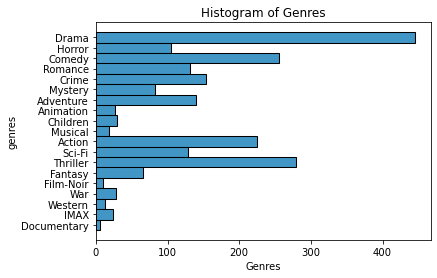

In [20]:
sns.histplot(data = movies_tall_df, y = 'genres').set(title='Histogram of Genres', xlabel='Genres')

It looks like our dataset mostly has Drama, Comedy, Thriller, Action, and Adventure movies.

## Multi-Label Classification

Now let's try to classify the data. First, we're going to use a k-NN classifier to try to see if we can do this. We'll use the tall dataset we produced above and try to classify on `genres` and then test with the training set we fed into the model. Then we're going to use `OneVsRestClassifier` with a Naïve Bayes, Logistic Regression, and Logistic Regression SVD.

### k-Nearest Neighbors

In [21]:
knn_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(
        stop_words=set(ENGLISH_STOP_WORDS),
lowercase=True,
        max_features=10000)
    ),
    ('class', KNeighborsClassifier(5))
])
knn_pipe.fit(movies_tall_df['script'], movies_tall_df['genres'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000,
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', 'anywhere', ...})),
                ('class', KNeighborsClassifier())])

In [22]:
pred_train = knn_pipe.predict(train['script'])
knn_5_accuracy_train = accuracy_score(train['genres'], pred_train)
print(knn_5_accuracy_train)

0.13663133097762073


So we've gotten about 13.6% accuracy on the training data. That's pretty awful. Let's use `GridSearchCV` to identify a better choice for the number of neighbors and update the model.

In [23]:
knn_pipe_2 = Pipeline([
    ('vectorize', TfidfVectorizer(
        stop_words=set(ENGLISH_STOP_WORDS),
lowercase=True, max_features=10000)),
('class', GridSearchCV(KNeighborsClassifier(), param_grid={
        'n_neighbors': [1, 2, 3, 5, 7, 10]
    }, n_jobs=NJOBS))
])
knn_pipe_2.fit(movies_tall_df['script'], movies_tall_df['genres'])
print(knn_pipe_2.named_steps['class'].best_params_)

{'n_neighbors': 3}


In [24]:
pred_train_k10 = knn_pipe_2.predict(movies_tall_df['script'])
knn_10_accuracy_train = accuracy_score(movies_tall_df['genres'], pred_train_k10)
print(knn_10_accuracy_train)

0.33548684817720353


With 3 neighbors, the model increased its accuracy to 33.5%. That's definitely better!

### OneVsRestClassifier

Let's see how a `OneVsRestClassifier` performs on our training data.

In [25]:
genres = ['Action', 'Adventure', 'Animation', 'Children'
    , 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX'
    , 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

#### Naïve Bayes

In [26]:
train_accuracy_nb = []
test_accuracy_nb = []

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(
                    lowercase=True,
                    max_features=10000,
                    stop_words=set(ENGLISH_STOP_WORDS)
                    )),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)
                    )),
            ])
print('{0: <15}'.format('Genre') + '{0: >8}'.format('Score'))
for genre in genres:
    # train the model using movie scripts and genres
    NB_pipeline.fit(train['script'], train[genre])
    # find accuracy on training data
    train_pred = NB_pipeline.predict(train['script'])
    train_accuracy_nb.append(accuracy_score(train[genre], train_pred))
    test_pred = NB_pipeline.predict(test['script'])
    test_accuracy_nb.append(accuracy_score(test[genre], test_pred))
    print('{0: <15}'.format(genre) + '{0: >10}'.format("%.8f" % accuracy_score(test[genre], test_pred)))

Genre             Score
Action         0.76056338
Adventure      0.86854460
Animation      0.95305164
Children       0.93896714
Comedy         0.62441315
Crime          0.81690141
Documentary    1.00000000
Drama          0.63849765
Fantasy        0.91549296
Film-Noir      0.98591549
Horror         0.89671362
IMAX           0.98122066
Musical        0.97183099
Mystery        0.93427230
Romance        0.80751174
Sci-Fi         0.86384977
Thriller       0.73239437
War            0.96244131
Western        0.99061033


Let's plot the train accuracy against the test accuracy for each genre and see how the model performed.

<AxesSubplot:title={'center':'MultiNomial Naive Bayes Accuracy for Genres'}>

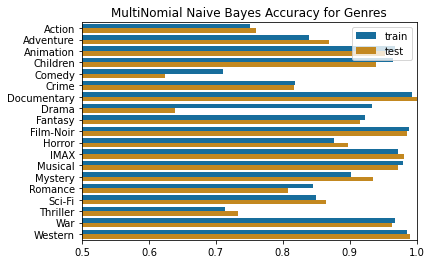

In [27]:
summary_data_nb = {'genre': ['Action', 'Action', 'Adventure', 'Adventure', 'Animation', 'Animation', 'Children', 'Children'
    , 'Comedy', 'Comedy', 'Crime', 'Crime', 'Documentary', 'Documentary', 'Drama', 'Drama', 'Fantasy', 'Fantasy', 'Film-Noir', 'Film-Noir', 'Horror', 'Horror', 'IMAX', 'IMAX'
    , 'Musical', 'Musical', 'Mystery', 'Mystery', 'Romance', 'Romance', 'Sci-Fi', 'Sci-Fi', 'Thriller', 'Thriller', 'War', 'War', 'Western', 'Western'],
'data': ['train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train'
    , 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test'],
'accuracy': []
}

for i in range(0, len(test_accuracy_nb)):
    summary_data_nb['accuracy'].append(train_accuracy_nb[i])
    summary_data_nb['accuracy'].append(test_accuracy_nb[i])

summary_plot_nb = sns.barplot(data=summary_data_nb, y='genre', x='accuracy', hue='data')
summary_plot_nb.set(title='MultiNomial Naive Bayes Accuracy for Genres', xlim=(0.5, 1.0))
summary_plot_nb

That looks much better! 

#### Linear with Stochastic Gradient Descent

Now, instead of using Naïve Bayes, let's use a linear model with stochastic gradient descent learning (`SGDClassifier`) with a loss function (`modified_huber`) and a penalty (`elasticnet`). 

In [28]:
train_accuracy_sgd = []
test_accuracy_sgd = []

sgd_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(
                    lowercase=True,
                    max_features=10000,
                    stop_words=set(ENGLISH_STOP_WORDS)
                )),
                ('clf', OneVsRestClassifier(SGDClassifier(loss='modified_huber', penalty='elasticnet')))
            ])
print('{0: <15}'.format('Genre') + '{0: >8}'.format('Score'))
for genre in genres:
    # train the model using movie scripts and genres
    sgd_pipeline.fit(train['script'], train[genre])
    # find accuracy on training data
    train_pred = sgd_pipeline.predict(train['script'])
    train_accuracy_sgd.append(accuracy_score(train[genre], train_pred))
    test_pred = sgd_pipeline.predict(test['script'])
    test_accuracy_sgd.append(accuracy_score(test[genre], test_pred))
    print('{0: <15}'.format(genre) + '{0: >10}'.format("%.8f" % accuracy_score(test[genre], test_pred)))

Genre             Score
Action         0.74178404
Adventure      0.81690141
Animation      0.96244131
Children       0.93896714
Comedy         0.62910798
Crime          0.79812207
Documentary    1.00000000
Drama          0.63380282
Fantasy        0.91549296
Film-Noir      0.98591549
Horror         0.86384977
IMAX           0.98122066
Musical        0.96713615
Mystery        0.92488263
Romance        0.77464789
Sci-Fi         0.83568075
Thriller       0.65727700
War            0.96244131
Western        0.99061033


<AxesSubplot:title={'center':'Linear Model with SGD Learning'}>

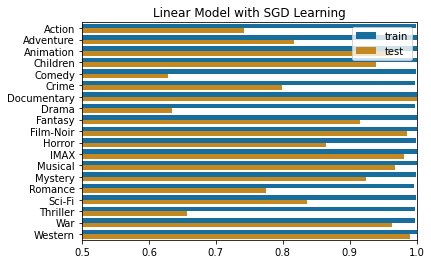

In [29]:
summary_data_sgd = {'genre': ['Action', 'Action', 'Adventure', 'Adventure', 'Animation', 'Animation', 'Children', 'Children'
    , 'Comedy', 'Comedy', 'Crime', 'Crime', 'Documentary', 'Documentary', 'Drama', 'Drama', 'Fantasy', 'Fantasy', 'Film-Noir', 'Film-Noir', 'Horror', 'Horror', 'IMAX', 'IMAX'
    , 'Musical', 'Musical', 'Mystery', 'Mystery', 'Romance', 'Romance', 'Sci-Fi', 'Sci-Fi', 'Thriller', 'Thriller', 'War', 'War', 'Western', 'Western'],
'data': ['train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train'
    , 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test'],
'accuracy': []
}

for i in range(0, len(test_accuracy_sgd)):
    summary_data_sgd['accuracy'].append(train_accuracy_sgd[i])
    summary_data_sgd['accuracy'].append(test_accuracy_sgd[i])

summary_plot_sgd = sns.barplot(data=summary_data_sgd, y='genre', x='accuracy', hue='data')
summary_plot_sgd.set(title='Linear Model with SGD Learning', xlim=(0.5, 1.0))
summary_plot_sgd

It looks like there's some serious overfitting with the stochastic gradient descent model. The accuracy on that training data is immense.

#### Logistic Regression with SVD-Transformed Texts

Lastly, let's use an SVD decomposition and `GridSearchCV` to identify the number of dimensions for our model.

In [30]:
train_accuracy_logreg_svd = []
test_accuracy_logreg_svd = []

svd_logreg_inner = Pipeline([
    ('latent', TruncatedSVD(random_state=rng)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=NJOBS))
])
svd_logreg = Pipeline([
    ('vectorize', TfidfVectorizer(
        stop_words=ENGLISH_STOP_WORDS, 
        max_features=10000,
        lowercase=True
        )), 
    ('class', GridSearchCV(svd_logreg_inner, param_grid={
        'latent__n_components': range(1, 50),
    }, n_jobs=NJOBS))
])
print('{0: <15}'.format('Genre') + '{0: >8}'.format('Score'))
for genre in genres:
    # train the model using movie scripts and genres
    svd_logreg.fit(train['script'], train[genre])
    # find accuracy on training data
    train_pred = svd_logreg.predict(train['script'])
    train_accuracy_logreg_svd.append(accuracy_score(train[genre], train_pred))
    test_pred = svd_logreg.predict(test['script'])
    test_accuracy_logreg_svd.append(accuracy_score(test[genre], test_pred))
    print('{0: <15}'.format(genre) + '{0: >10}'.format("%.8f" % accuracy_score(test[genre], test_pred)))

Genre             Score
Action         0.76056338
Adventure      0.86854460
Animation      0.95305164
Children       0.93896714
Comedy         0.63380282
Crime          0.81690141
Documentary    1.00000000
Drama          0.55868545
Fantasy        0.91549296
Film-Noir      0.98591549
Horror         0.89671362
IMAX           0.98122066
Musical        0.97183099
Mystery        0.93427230
Romance        0.80751174
Sci-Fi         0.86384977
Thriller       0.73239437
War            0.96244131
Western        0.99061033


<AxesSubplot:title={'center':'Logistic Regression SVD Accuracy'}>

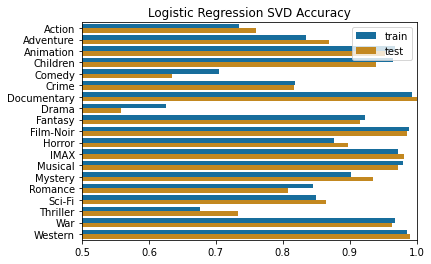

In [31]:
summary_data_logreg_svd = {'genre': ['Action', 'Action', 'Adventure', 'Adventure', 'Animation', 'Animation', 'Children', 'Children'
    , 'Comedy', 'Comedy', 'Crime', 'Crime', 'Documentary', 'Documentary', 'Drama', 'Drama', 'Fantasy', 'Fantasy', 'Film-Noir', 'Film-Noir', 'Horror', 'Horror', 'IMAX', 'IMAX'
    , 'Musical', 'Musical', 'Mystery', 'Mystery', 'Romance', 'Romance', 'Sci-Fi', 'Sci-Fi', 'Thriller', 'Thriller', 'War', 'War', 'Western', 'Western'],
'data': ['train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train'
    , 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test', 'train', 'test'],
'accuracy': []
}

for i in range(0, len(test_accuracy_nb)):
    summary_data_logreg_svd['accuracy'].append(train_accuracy_logreg_svd[i])
    summary_data_logreg_svd['accuracy'].append(test_accuracy_logreg_svd[i])

summary_plot_logreg_svd = sns.barplot(data=summary_data_logreg_svd, y='genre', x='accuracy', hue='data')
summary_plot_logreg_svd.set(title='Logistic Regression SVD Accuracy', xlim=(0.5, 1.0))
summary_plot_logreg_svd

## Accuracy Summary

The accuracies on each of these models seem to be fairly consistent. The only genre that seems to have a really different prediction between Naive Bayes and Logistic SVD is Drama. Naive Bayes does a better job predicting on the test set.

The models were able to predict genres like `Documentary` and `Film-Noir` much better than the rest of the categories. That's probably because of how different the vocabulary used in those films are compared to everything else. Drama definitely performed the worst. I suspect the scripts in that genre have words in common with numerous other categories so it's not as easy to identify a film as `Drama` just by its script.

In [32]:
print('{0: <15}'.format('Genre') + '{0: >15}'.format('Naive Bayes') + '{0: >15}'.format('Linear SGD') + '{0: >15}'.format('Logistic SVD'))
for i in range(0, len(genres)):
    print('{0: <15}'.format(genres[i]) + '{0: >15}'.format("%.5f" % test_accuracy_nb[i])
        + '{0: >15}'.format("%.5f" % test_accuracy_sgd[i])
            + '{0: >15}'.format("%.5f" % test_accuracy_logreg_svd[i]))

Genre              Naive Bayes     Linear SGD   Logistic SVD
Action                 0.76056        0.74178        0.76056
Adventure              0.86854        0.81690        0.86854
Animation              0.95305        0.96244        0.95305
Children               0.93897        0.93897        0.93897
Comedy                 0.62441        0.62911        0.63380
Crime                  0.81690        0.79812        0.81690
Documentary            1.00000        1.00000        1.00000
Drama                  0.63850        0.63380        0.55869
Fantasy                0.91549        0.91549        0.91549
Film-Noir              0.98592        0.98592        0.98592
Horror                 0.89671        0.86385        0.89671
IMAX                   0.98122        0.98122        0.98122
Musical                0.97183        0.96714        0.97183
Mystery                0.93427        0.92488        0.93427
Romance                0.80751        0.77465        0.80751
Sci-Fi                 0

## Sources

- The Movie Database: https://www.themoviedb.org/ 
- MovieLens: https://grouplens.org/datasets/movielens/25m/
- IMSDB: https://imsdb.com
- Aveek Saha's Movie Script Database: https://github.com/Aveek-Saha/Movie-Script-Database
- SciKit-Learn Docs: https://scikit-learn.org/stable/modules/multiclass.html#ovr-classification